In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, pylab as pl, itertools as it
libPath = 'project1/scripts'
import sys
if not libPath in sys.path: sys.path.append(libPath)
from implementations import *
from proj1_helpers import *

# 1. Choosing a model

## 1.1. 1st order simple polynomial

Simple linear model:
$y = w_1x_1+\dots + w_nx_n$

Import, clean and standardize data:

In [2]:
y, inputs, ids = load_clean_csv("train.csv", False, 'avg')
print('Size of output array: ', y.shape)
print('Size of input matrix: ', inputs.shape)
print('Size of ids array: ', ids.shape)

Size of output array:  (250000,)
Size of input matrix:  (250000, 30)
Size of ids array:  (250000,)


In [3]:
feature_cols = [1, 3, 4, 8, 10, 11, 12, 13, 22]
# feature_cols = [0, 1, 2, 7, 10, 11, 13, 19]
N_VALID_FEATURES = len(feature_cols)
N_FEATURES = inputs.shape[1]
N_DATA = len(inputs)

Check if output array contains only +-1:

In [4]:
print('Output data contains only +1 or -1?', all(np.bitwise_or(y==1, y==-1)))

Output data contains only +1 or -1? True


Check if data is standardized:

In [5]:
print("Is the mean zero?: ", np.allclose(np.mean(inputs,0), 0, 1e-5))
print("Is the standard deviation equal to 1?: ", np.allclose(np.std(inputs,0),1, 1e-5))

Is the mean zero?:  True
Is the standard deviation equal to 1?:  True


Functions for k-fold cross validation:

In [6]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, tx, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    y_te = y[k_indices[k]]    
    tx_te = tx[k_indices[k]]
    
    y_tr = np.delete(y, k_indices[k], axis=0)
    tx_tr = np.delete(tx, k_indices[k], axis=0)
    # ***************************************************
    w, loss_tr = ridge_regression(y_tr, tx_tr, lambda_)
    # ***************************************************
    loss_te = compute_mse(y_te, tx_te, w)
    loss_tr = compute_mse(y_tr, tx_tr, w)
    # ***************************************************
    return loss_tr, loss_te, w

def build_poly(x, degree):
    """Polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

Algorithm:

Step 1. Build a polynomial base of degree N from the important feature columns;

Step 2. Build the hyperparameter $\lambda$ array;

Step 3. Build the k-fold indexes used to split the data in k sets;

Step 4. Sweep through the hyperparameter array: for each $\lambda$, train the dataset using cross validation.

Step 5. Average the RMSE for training and test sets.


In [7]:
# Setting the input data, the degree and the number of partitions
x = inputs[:, feature_cols]
degree = 1
k_fold = 4

# Step 1
tx = build_poly(x, degree)
print('Number of variables: ', tx.shape[1])
# Step 2
lambdas = np.logspace(-4, 0, 30)

# Step 3
k_indices = build_k_indices(y, k_fold, 1)

rmse_tr = []
rmse_te = []
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation(y, tx, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(np.sqrt(2*rmse_tr_tmp)))
    rmse_te.append(np.mean(np.sqrt(2*rmse_te_tmp)))


Number of variables:  10


Plot results across the hyperparameters:

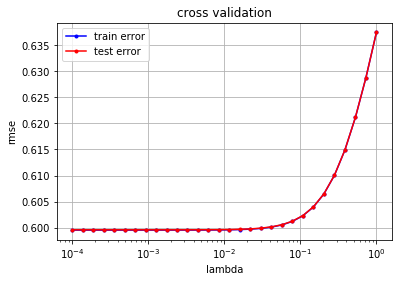

In [8]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

Optimal $\lambda$:

In [9]:
lambdas[np.argmin(rmse_te)]

0.0004893900918477494

Using the optimal $\lambda$, obtain the weights with half the training data:

In [10]:
x_TEST = inputs[:,feature_cols]
x_train, y_train, x_test, y_test = split_data(x_TEST, y, 0.5)

tx_train = build_poly(x_train, degree)
tx_test = build_poly(x_test, degree)


weights, mse = ridge_regression(y_train, tx_train, lambdas[np.argmin(rmse_te)])

In [11]:
weights

array([-0.31466101, -0.23588271, -0.00701623,  0.09970047, -0.0379914 ,
       -0.00835838,  0.13690117,  0.0724781 ,  0.16544714,  0.00423166])

In [12]:
y_pred = predict_labels(weights, tx_test)

compute_score(y_test, y_pred)

rmse_train = np.sqrt(2*compute_mse(y_train, tx_train, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_test, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)


Total correct: 90549.0 
Total incorrect: 34451.0 
Correct percentage: 72.4392 %
-----------------------------
Train RMSE: 0.8484267683678935 , Test RMSE: 0.8473716067764123


## 1.2. N-th order simple polynomial

4-th order linear model:
$y = w_0+w_1x_1+\dots+ w_4x_1^4 +\dots + w_nx_2^4$

In [13]:
# Setting the input data, the degree and the number of partitions
x = inputs[:,feature_cols]
degree = 4
k_fold = 4

# Step 1
tx = build_poly(x, degree)
print('Number of variables: ', tx.shape[1])
# Step 2
lambdas = np.logspace(-4, 0, 30)

# Step 3
k_indices = build_k_indices(y, k_fold, 1)

rmse_tr = []
rmse_te = []
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation(y, tx, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.mean(np.sqrt(2*rmse_tr_tmp)))
    rmse_te.append(np.mean(np.sqrt(2*rmse_te_tmp)))


Number of variables:  37


Plot results across the hyperparameters:

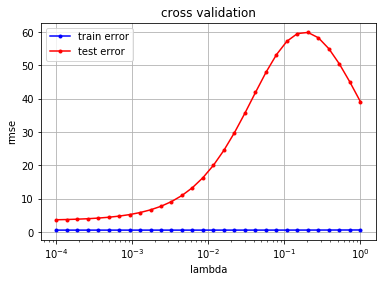

In [14]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

Optimal $\lambda$:

In [15]:
lambdas[np.argmin(rmse_te)]

0.0001

In [16]:
x_TEST = inputs[:,feature_cols]
x_train, y_train, x_test, y_test = split_data(x_TEST, y, 0.5)

tx_train = build_poly(x_train, degree)
tx_test = build_poly(x_test, degree)

weights, mse = ridge_regression(y_train, tx_train, lambdas[np.argmin(rmse_te)])

In [17]:
y_pred = predict_labels(weights, tx_test)

compute_score(y_test, y_pred)

rmse_train = np.sqrt(2*compute_mse(y_train, tx_train, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_test, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)



Total correct: 93778.0 
Total incorrect: 31222.0 
Correct percentage: 75.0224 %
-----------------------------
Train RMSE: 0.8167840166132061 , Test RMSE: 4.605220249380274


## 1.3. A more complicated model

For example, order 2:
$y=w_0 + w_1x_1 + w_2x_2 +w_3x_1^2 +w_4x_2^2+w_5x_1x_2+\dots$

First, let's redefine the build_poly function for a complete combination of features: 

In [93]:
def build_poly_plus(x, degree):
    """
    Builds polynomial basis function of a certain degree combining all features.
    """
    poly = np.ones((len(x), 1))

    for deg in range(1, degree+1):
        print(deg)
        if deg == 1:
            poly = np.c_[poly, x]
        else:
            for i in it.combinations_with_replacement(range(x.shape[1]),deg):
                poly = np.c_[poly, np.prod(x[:,i],1)]
    return poly

In [70]:
# import itertools

# # TODO: Optimize. Very slow!
# def build_mult_comb(tx, deg, cols=[]):
#     """
#     Returns all multiplicative combinations of the specified columns for degree deg.
#     For len(col) = D', there are (D' choose deg) combinations of columns that get
#     returned as a matrix.
#     If cols is not given, it returns the combinations of all columns of tx.
#     """
#     N = tx.shape[0]
#     if (cols == []):
#         comb_iter = itertools.combinations_with_replacement(range(tx.shape[1]), deg)
#     else:
#         comb_iter = itertools.combinations_with_replacement(cols, deg)
#     mult = []
#     for comb in comb_iter:
#         mult_col = np.ones(N)
#         for idx in comb:
#             tx_col = tx[:,idx]
#             mult_col = np.multiply(mult_col, tx_col)
#         mult.append(mult_col.tolist())
#     return np.array(mult).T

# def build_poly_adv(tx, degree, cols=[]):
#     """
#     Builds full polynomial basis function for input data matrix tx, for j=0 up to j=degree,
#     where the result will be a matrix of form:
#     [1, tx, comb_mult(tx, 2), ..., comb_mult(tx, j)]
#     comb_mult(tx, 2) denotes all multiplicative combinations of the selected columns of tx.
#     If cols is not given, it returns the combinations of all columns of tx.
#     """
#     poly = np.ones((tx.shape[0], 1))

#     for j in range(1, degree+1):
#         mult = build_mult_comb(tx, j, cols)
#         poly = np.column_stack((poly, mult))

#     return poly

In [105]:
# Load input data, choose degree and partition number
x = inputs[:,feature_cols]
degree = 4
k_fold = 4

In [106]:
# Step 1
tx = build_poly_plus(x, degree)
print('Number of variables: ', tx.shape[1])

1
2
3
4
Number of variables:  715


In [107]:
# Step 2
lambdas = np.logspace(-5, 0, 20)

# Step 3
k_indices = build_k_indices(y, k_fold, 1)

rmse_tr = []
rmse_te = []
for l in lambdas:
    rmse_tr_tmp = []
    rmse_te_tmp = []
    for k in range(k_fold):
        loss_tr, loss_te, w = cross_validation(y, tx, k_indices, k, l, degree)
        rmse_tr_tmp.append(loss_tr)
        rmse_te_tmp.append(loss_te)
    rmse_tr.append(np.sqrt(2*np.mean(rmse_tr_tmp)))
    rmse_te.append(np.sqrt(2*np.mean(rmse_te_tmp)))
    print("lambda={la:.9f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               la=l, tr=rmse_tr[-1], te=rmse_te[-1]))


lambda=0.000010000, Training RMSE=0.786, Testing RMSE=42.037
lambda=0.000018330, Training RMSE=0.786, Testing RMSE=42.041
lambda=0.000033598, Training RMSE=0.786, Testing RMSE=42.048
lambda=0.000061585, Training RMSE=0.786, Testing RMSE=42.057
lambda=0.000112884, Training RMSE=0.786, Testing RMSE=42.061
lambda=0.000206914, Training RMSE=0.786, Testing RMSE=42.033
lambda=0.000379269, Training RMSE=0.786, Testing RMSE=41.883
lambda=0.000695193, Training RMSE=0.786, Testing RMSE=41.366
lambda=0.001274275, Training RMSE=0.786, Testing RMSE=39.925
lambda=0.002335721, Training RMSE=0.787, Testing RMSE=36.500
lambda=0.004281332, Training RMSE=0.787, Testing RMSE=29.272
lambda=0.007847600, Training RMSE=0.788, Testing RMSE=15.544
lambda=0.014384499, Training RMSE=0.790, Testing RMSE=7.963
lambda=0.026366509, Training RMSE=0.792, Testing RMSE=42.119
lambda=0.048329302, Training RMSE=0.796, Testing RMSE=84.262
lambda=0.088586679, Training RMSE=0.801, Testing RMSE=125.412
lambda=0.162377674, Trai

Plot results across the hyperparameters:

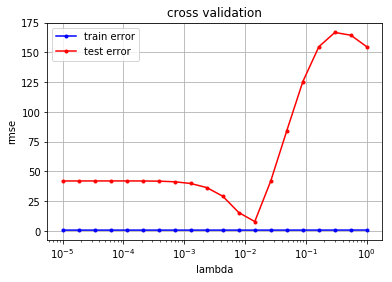

In [108]:
plt.semilogx(lambdas, rmse_tr, marker=".", color='b', label='train error')
plt.semilogx(lambdas, rmse_te, marker=".", color='r', label='test error')
plt.xlabel("lambda")
plt.ylabel("rmse")
plt.title("cross validation")
plt.legend(loc=2)
plt.grid(True)

Optimal $\lambda$:

In [109]:
lambdas[np.argmin(rmse_te)]

0.01438449888287663

In [110]:
x_TEST = inputs[:,feature_cols]
x_train, y_train, x_test, y_test = split_data(x_TEST, y, 0.5)

tx_train = build_poly_plus(x_train, degree)
tx_test = build_poly_plus(x_test, degree)

weights, mse = ridge_regression(y_train, tx_train, lambdas[np.argmin(rmse_te)])

1
2
3
4
1
2
3
4


In [111]:
y_pred = predict_labels(weights, tx_test)

compute_score(y_test, y_pred)

rmse_train = np.sqrt(2*compute_mse(y_train, tx_train, weights))
rmse_test = np.sqrt(2*compute_mse(y_test, tx_test, weights))
print("Train RMSE:", rmse_train, ", Test RMSE:", rmse_test)



Total correct: 95883.0 
Total incorrect: 29117.0 
Correct percentage: 76.7064 %
Train RMSE: 0.7888770673469889 , Test RMSE: 93.08001586717604


# Test set

In [112]:
y_test, inputs_test, ids_test = load_clean_csv('test.csv', False, "avg", True)

In [113]:
# tx_test = build_poly(inputs_test[:,feature_cols], degree)
tx_test = build_poly_plus(inputs_test[:,feature_cols], degree)
tx_test.shape

1
2
3
4


(568238, 715)

In [114]:
y_pred = predict_labels(weights, tx_test)
y_pred.shape

(568238,)

In [115]:
create_csv_submission(ids_test, y_pred, 'prediction.csv')
